In [41]:
import pandas as pd
import numpy as np
import statistics
%matplotlib inline
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import seaborn as sns
import re
from scipy.stats import f_oneway #AVONA_test

              #1
 Завантажте цей набір даних IKEA.
 https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv

In [42]:
df_ik = pd.read_csv("F:\ikea.csv",sep=',', encoding="UTF-8", error_bad_lines=False)

C:\Users\user\AppData\Local\Temp\ipykernel_5592\3959557650.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_ik = pd.read_csv("F:\ikea.csv",sep=',', encoding="UTF-8", error_bad_lines=False)


In [43]:

with pd.option_context('display.max_rows', 5, 'display.max_columns', 15):
   print(df_ik)

      Unnamed: 0   item_id       name       category   price     old_price  \
0              0  90420332   FREKVENS  Bar furniture   265.0  No old price   
1              1    368814  NORDVIKEN  Bar furniture   995.0  No old price   
...          ...       ...        ...            ...     ...           ...   
3692        3692  89157573    ELVARLI      Wardrobes  2745.0      SR 3,130   
3693        3693  69157376    ELVARLI      Wardrobes  1231.0      SR 1,535   

      sellable_online                                               link  \
0                True  https://www.ikea.com/sa/en/p/frekvens-bar-tabl...   
1               False  https://www.ikea.com/sa/en/p/nordviken-bar-tab...   
...               ...                                                ...   
3692             True  https://www.ikea.com/sa/en/p/elvarli-3-section...   
3693             True  https://www.ikea.com/sa/en/p/elvarli-2-section...   

     other_colors                                 short_description  \
0  

              #2
Виконайте дослідження для набору даних, включаючи описову статистику та візуалізації. Опишіть результати.

In [ ]:
# Перевірка данних по колонках:
for col in df_ik:
    print(col, '=', list(df_ik[col].unique()))


Перевірка данних по колонках: бачимо що в колонці designer є не відповідні значення:

'IKEA of Sweden/Tina Christensen', 'IKEA of Sweden/K Hagberg/M Hagberg', 'Ola Wihlborg/IKEA of Sweden', 
'504.689.53 Small and easy-to-place chair-bed which can easily be converted into a single bed.......

В колонці 'old_price' є зачення типів:'No old price','SR 50/4 pack', 'SR 9,430'.
Треба робити преретворення в цих колонках ("чистимо дані")


In [45]:
# Пертворюємо данні в колонці 'old_price'
# Створюємо функію для перетворень в 'No old price'

def clean_old_price(df_ik):
    # замінюємо значеннями з колонки 'price', ячейки де є 'No old price'
    if df_ik['old_price'] == 'No old price':
        return df_ik['price']

    # Замінюємо SR та кому в числах  в колонці old_price
    elif df_ik['old_price'][-4:] != 'pack':  # перевіряємо  останні 4 символи на «pack», якщо не pack,
                                             # то робимо заміну, якщо «pack» то повернемо nan
        return float(str(df_ik['old_price'])[3:].replace(',', '')) #Якщо не  «пакет», то [3:] робить заміну 3 -го символу.
                                                                   
    else:
        return np.nan

In [47]:
df_ik['old_price'] = df_ik.apply(clean_old_price, axis=1)# За допомогоє apply застосовуємо нашу фун-цію до строк
df_ik['old_price'] = df_ik['old_price'].fillna(df_ik['price'])  # оскільки ячейки де був 'pack' були замінені на nan,
                                                        # тут заміщаємо значеня nan на значення з колонки 'price'

In [ ]:
 print(df_ik['old_price'].unique())# перевіряємо,все вийшло [2.650e+02 9.950e+02 2.095e+03 6.900e+01 2.250e+02 

In [48]:
# Нормалізуємо данні в колонці 'designer'
df_ik.insert(14, 'description of furniture', '')# створюємо колонку для переносу данних про опис меблів з колонки дизайнерів
p = r'(^\d{3}\..*$)'# регуляриний вираз
for x in range(df_ik.shape[0]):
    if df_ik['designer'].str.match(p).loc[x] == True:
        df_ik.loc[x,'description of furniture'] = df_ik.loc[x, 'designer']
        df_ik.loc[x,'designer'] = 'NOT DESIGNER'
    else:
        df_ik.loc[x,'description of furniture'] = 'No description of furniture '


In [ ]:
print(df_ik['designer'].unique())# 'K Hagberg/M Hagberg/IKEA of Sweden''Jon Karlsson' 'IKEA of Sweden/Carina Bengs'...

In [49]:
# ще є "зайва" інформація, яку прибираємо за допомою replace
df_ik['designer'] = df_ik['designer'].str.replace('/IKEA of Sweden', '')
df_ik['designer'] = df_ik['designer'].str.replace('IKEA of Sweden/', '')

In [ ]:
print(df_ik['designer'].unique())# перевіряємо

'Carina Bengs' 'K Hagberg/M Hagberg' 'Sarah Fager'
 'Ehlén Johansson' 'Nike Karlsson' 'Maja Ganszyniec' 'Karl Malmvall'
 'John/Jonas/Petrus/Paul/Caroline' 'Nike Karlsson/Maja Ganszyniec'
 'J Karlsson/N Karlsson' 'IKEA of Sweden'
 'Nike Karlsson/J Karlsson/N Karlsson' 'Ola Wihlborg' 'Tina Christensen'
 'NOT DESIGNER' 'Ebba Strandmark' 'Jon Karlsson' 'David Wahl'

In [14]:
# Отримаємо показники описової статистики (тільки для числових значень)
with pd.option_context('display.max_rows', 20, 'display.max_columns', 15):
   print(df_ik.describe())

        Unnamed: 0       item_id        price    old_price        depth  \
count  3694.000000  3.694000e+03  3694.000000  3694.000000  2231.000000   
mean   1846.500000  4.863240e+07  1078.208419  1125.014348    54.379202   
std    1066.510275  2.888709e+07  1374.652494  1443.543124    29.958351   
min       0.000000  5.848700e+04     3.000000     3.000000     1.000000   
25%     923.250000  2.039057e+07   180.900000   195.000000    38.000000   
50%    1846.500000  4.928808e+07   544.700000   550.000000    47.000000   
75%    2769.750000  7.040357e+07  1429.500000  1495.000000    60.000000   
max    3693.000000  9.993262e+07  9585.000000  9985.000000   257.000000   

            height        width  
count  2706.000000  3105.000000  
mean    101.679970   104.470853  
std      61.097585    71.133771  
min       1.000000     1.000000  
25%      67.000000    60.000000  
50%      83.000000    80.000000  
75%     124.000000   140.000000  
max     700.000000   420.000000  


З даних можна зробити наступні висновки:
a) Колонка  «price»: маємо доволі суттєвий розмах варіації: max- min = 9585,00-3,00=9582,00;
що пояснюється різноманітним  асортимент продукції, «від серветок до шаф»;
б) середня ціна  = 1078,21 SR;
в) (фіксована щільність - 75%-25%)  50% значень знаходиться в діапазоні від 180,90SR до 1429,50 SR
(між жовтими лінініями на графіку ),тобто 50% ,товарів коштують від 180,90 до 1429,50 SR;
На основі цих статистичних показників можна зробити висновок, що значення «price» далеке від нормального розподілу.

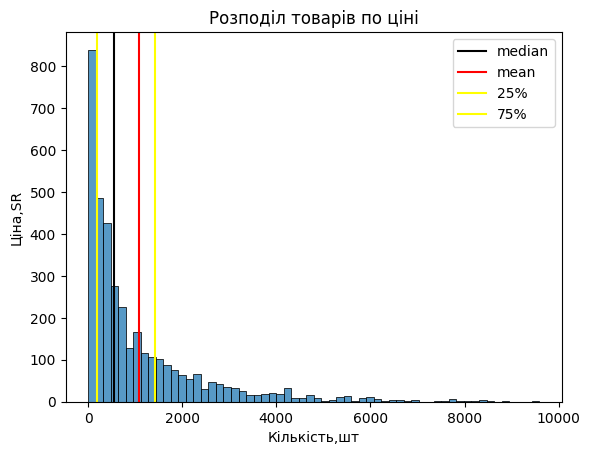

In [29]:
# Про це свідчить і графік:
sns.histplot(df_ik['price'])
plt.axvline(np.median(df_ik['price']), color='black', label='median')
plt.axvline(np.mean(df_ik['price']), color='red', label='mean')
plt.axvline(np.percentile(df_ik['price'], q=25), color='yellow', label='25%')
plt.axvline(np.percentile(df_ik['price'], q=75), color='yellow', label='75%')
plt.legend()
plt.xlabel('Кількість,шт')
plt.ylabel('Ціна,SR')
plt.title('Розподіл товарів по ціні')
plt.show()

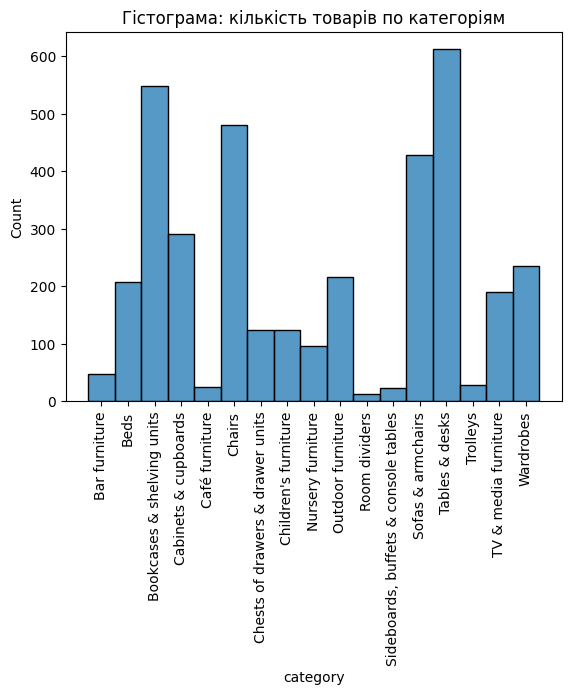

In [25]:

sns.histplot(df_ik['category'], x=df_ik['category'])
plt.title('Гістограма: кількість товарів по категоріям')
plt.xticks(rotation=90)
plt.show()

Судячи з графіку, робимо висновок, що найширший асортимент меблів в категорії  "Tables & desks"(приблизно 600 найменувань).
В катигоріях "Bookcases & shelving units","Chairs", "Sofas & armchairs" від 400 до 550 найменувань.
"Найбідніший" ассортимент в категорії меблів "Room dividers" .

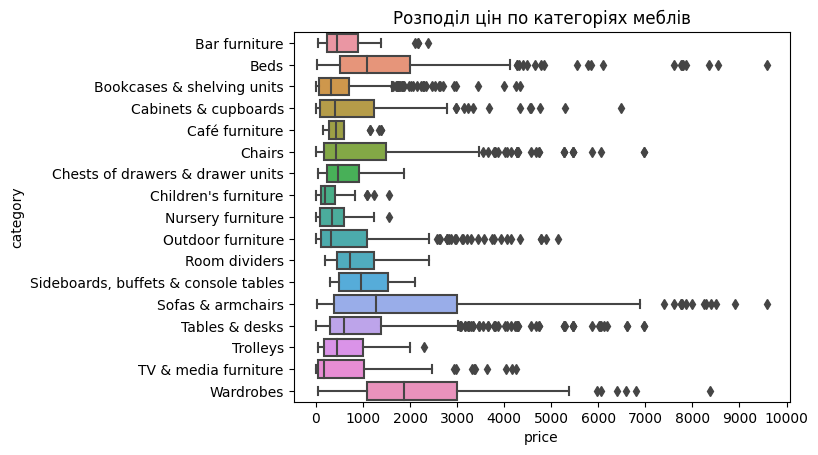

In [26]:
# Розподіл цін по категоріях меблів
sns.boxplot(data=df_ik, x=df_ik['price'], y='category')
plt.title('Розподіл цін по категоріях меблів')
plt.xticks(range(0,11000,1000))
plt.show()

Графік показує роздопіл цін по категоріям меблів. В 'boxe' відображаються ціни з 25% по 75 % меблів в кожній категорії,
і медіанну ціну. 'Вуса' містять розмах ціни min - max  (якщо не враховавати викиди)  Так, наприклад, в категорії 
'Sofas & armchairs' 75% товарів коштують від 0 до 3 тис, а вартість 25 % меблів,в цій категорії, знаходяться в діапазона від 3 до 7 тис.,також є 'не масові' товари від 7 до 10 тис (наші викиди на графіку)

In [31]:
# Після "очистки" та претворення колонки 'old_price',створюємо та заповнюємо нові колонки 'discount,SR' та  'discount'

df_ik.insert(15,'discount,SR', '')
df_ik.insert(16,'discount', '')
df_ik['discount,SR'] = df_ik['old_price']-df_ik['price']
df_ik['discount'] = round((df_ik['old_price']-df_ik['price'])*100/df_ik['old_price'],2)
print(df_ik[['discount,SR','discount']])

      discount,SR  discount
0             0.0      0.00
1             0.0      0.00
2             0.0      0.00
3             0.0      0.00
4             0.0      0.00
...           ...       ...
3689         70.0      8.54
3690        183.0     10.43
3691        126.0     12.00
3692        385.0     12.30
3693        304.0     19.80

[3694 rows x 2 columns]


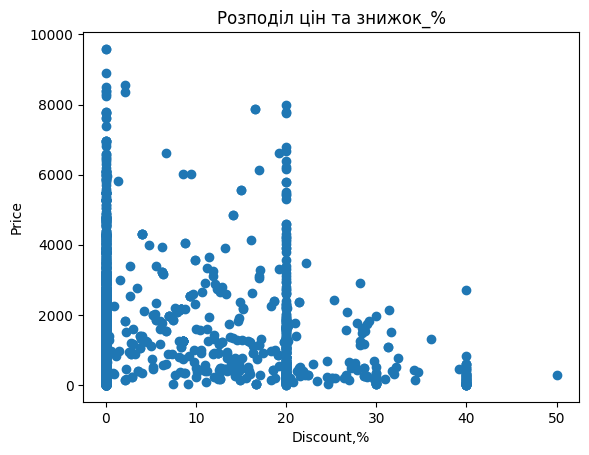

In [32]:
# Будуємо графік 'Розподіл цін та знижок_%'
plt.scatter(df_ik['discount'], df_ik['price'])
plt.xlabel('Discount,%')
plt.ylabel('Price')
plt.title('Розподіл цін та знижок_%')
plt.show()

На графіку 'Розподіл цін та знижок_%' видно, що на більшіть товарів взагалі не робили знижок.
Системні знижка 20% застосовувалась на товари від min ціни до 5000 SR, найбільша знижка 50% була зроблена на товар, який коштував приблизно 500 SR.
З графіку видно що в основному знижки застосовувались до товарів вартістью до 5000.

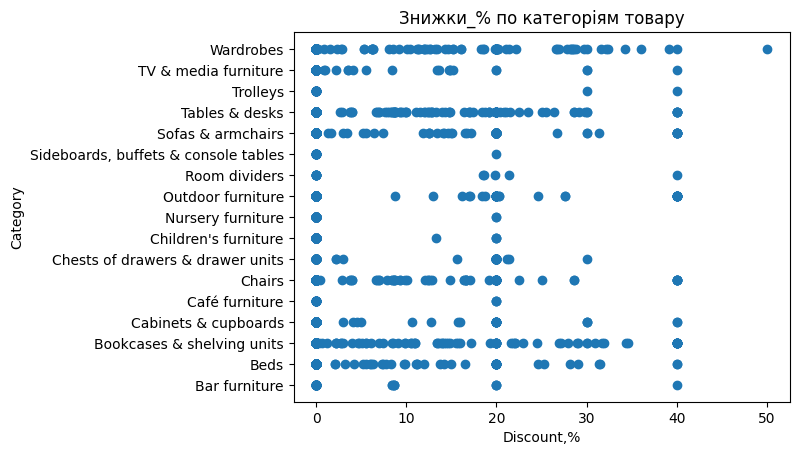

In [33]:
# Знижки_% по категоріям товару
plt.scatter(df_ik['discount'], df_ik['category'])
plt.xlabel('Discount,%')
plt.ylabel('Сategory')
plt.title('Знижки_% по категоріям товару')
plt.show()

З графіку "Знижки_% по категоріям товару" видно, що "найходовіша" знижка це 20%, яка була
застосована у всіх категоріях меблів, в яких давались знижки.
В 12 із 17 категорій були застосовані знижка 40%. 
Знижки до 10% надавалися в 10 категоріях из 17.
На меблі з категорій: Wardrobes (тут і найбільша знижка 50%),Bookcases & shelving units, Tables & desks, 
найбільша кількість наданних знижок.
А в категоріях Sideboards, buffets & console tables,Cabinets & cupboards  - найменша.   

In [35]:
# Аналізуємо структуру товарів: чи надавалась на них знижка чи ні
# За допомогою методу assign додаємо категорійний стовбець на основі стобця "discount": чи є знижка  ТАК/НІ
df_ik=df_ik.assign(sales = df_ik.discount.apply(lambda x: 'YES' if x > 0 else 'NO'))

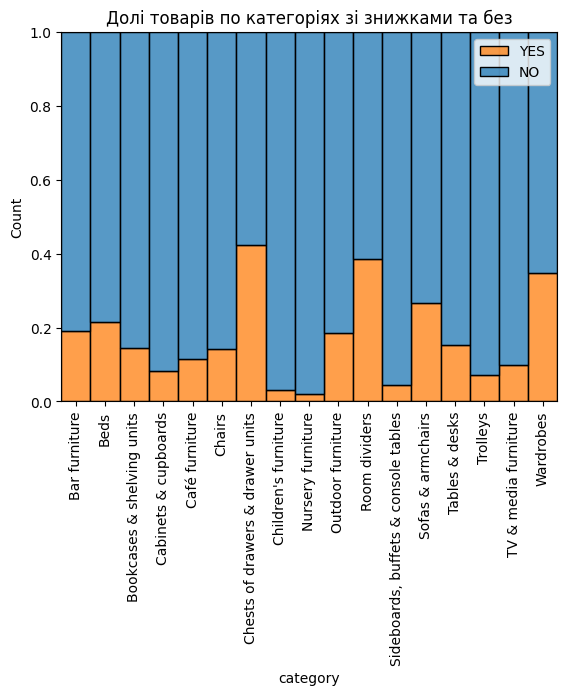

In [36]:
# Доля товарів по категоріях зі знижками та без
df_ik=df_ik.assign(sales = df_ik.discount.apply(lambda x: 'YES' if x > 0 else 'NO'))
sns.histplot(x='category', data = df_ik,
             hue='sales',
             multiple='fill')
plt.title('Долі товарів по категоріях зі знижками та без')
plt.xticks(rotation=90)
plt.legend(['YES','NO'])
plt.show()

З графіку видно, в категорії "Chests of drawers & drawer units" знижки були надані більш ніж на 40 % товарів. 
Також в категоріях "Room dividers", "Sofas & armchairs" та "Wardrobes" приблизно на третину товарів були надані знижки.
В категоріях: "Bookcases & shelving units","Bar furniture", "Beds", "Outdoor furniture","Tables & desks", "Chairs" - від 10% до 20 % товарів отримали знижки.
До товарів в категоріях "Children's furniture", "TV & media furniture","Cabinets & cupboards","Trolleys", "Sideboards, buffets & console tables" - були застосованя знижки меньше 10% від ціни. 
А товарам в "Nursery furniture" було надано найменьша кількість знижок (приблизно 3-5% товарі продавались зі знижкою).

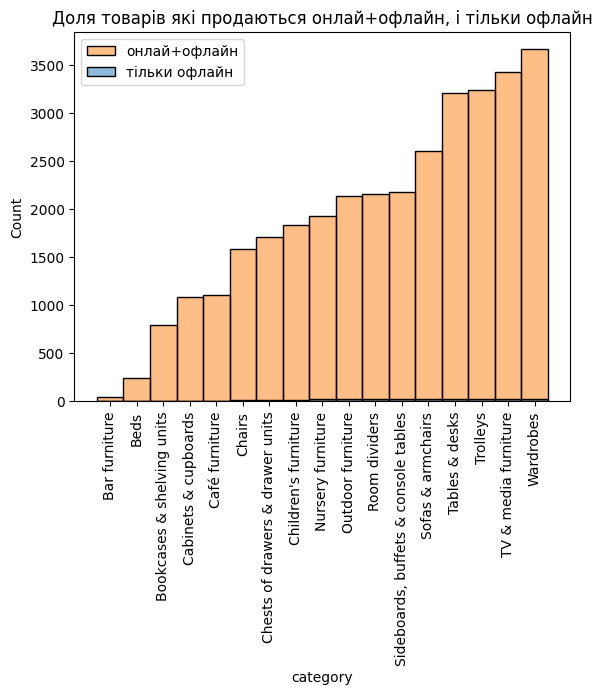

In [37]:
# Доля товарів які продаються онлай+офлайн, і тільки офлайн
sns.histplot(x='category', data = df_ik,
             hue='sellable_online', cumulative='stack')
plt.title('Доля товарів які продаються онлай+офлайн, і тільки офлайн')
plt.xticks(rotation=90)
plt.legend(['онлай+офлайн','тільки офлайн'])
plt.show()

Судячи з графіку, доля товарів які не прадстваленні в інтернет магазини, а продаються тільки офлайн, дуже мала

In [10]:
#Видаляємо не потрібні стовці
df_ik=df_ik.drop(['depth', 'height','width','link'], axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_14424\4170070113.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_ik.corr(), annot = True, cmap= 'coolwarm')


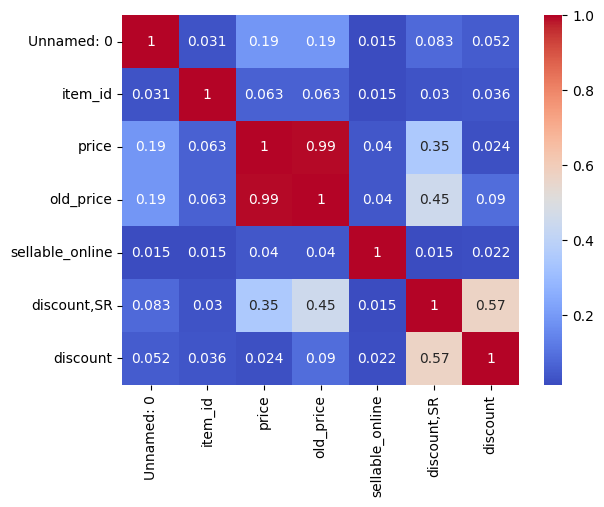

In [40]:
sns.heatmap(df_ik.corr(), annot = True, cmap= 'coolwarm')
plt.show()

По матриці видно, що достататьо тісної корреляції  між змінними  не має. Висоий коєфіцієнт кореляції між price
& old_price зумовлений(на мою думку), тим що при перетворенні стовця "old_price" використовувались значення з колонки price,
тому досліджувати цей взаємозвязок не бачу сенесу. 

 #3
3. На основі EDA і вашого здорового глузду виберіть дві
гіпотези, які ви хочете перевірити/проаналізувати. Для кожного
гіпотези перерахуйте нульову гіпотезу та інші можливі
альтернативні гіпотези, розробте тести, щоб розрізняти їх, та
виконайте їх. Опишіть результати.

In [50]:
# 3.1) Гіпотеза: H0 = Категорії товару та дизайнери не пов'язані між собою .
# H1 = Існує певна залежність між категоріями товару та дизайнерами.
# Зведенна таблиця по категоріям, дизайнерам, ціна
des_pivot = pd.pivot_table(df_ik, columns= 'category', values='price', index= 'designer', aggfunc='mean', fill_value=0)
сhi2_stat, p_val, dof, ex = stats.chi2_contingency(des_pivot)
print(f"\nResults of Xi2-test:")
print(f"Chi2 statistsc: {сhi2_stat:.4f}")
print(f"P-value:{p_val:.4f}")


Results of Xi2-test:
Chi2 statistsc: 3175116.5282
P-value:0.0000


Results of Xi2-test:
Chi2 statistsc: 3175116.5282
P-value:0.0000
P-value = 0,00 меньше рівня значущості (0,05 - для екомічних показників), отже можна відкинути нольову гіпотезу про 
незалежність категорій товару і дизайнерів.
Та приймаеться альтернативна гіпотеза: існує певна залежність між категоріями товарів і дизайнерів

3.2)Друга пара гіпотез:
Н0 =  Середні ціни товарів не залежать від категорії товарів;
Н1  = Середні ціни товарів залежать від категорії товарів

AVONA_test
Основна ідея одностороннього дисперсійного аналізу полягає у тому, щоб взяти незалежні випадкові вибірки з кожної групи,
а потім обчислити вибіркові середні значення для кожної групи. 
Після цього порівняйте варіацію вибіркових середніх серед груп з варіацією всередині груп. 
Нарешті, прийміть рішення на основі тестової статистики, чи рівні середні значення всіх груп чи ні.

In [42]:
avona_rez = f_oneway(df_ik[df_ik['category'] == "Children's furniture"]['price'],
                     df_ik[df_ik['category'] == 'Nursery furniture']['price'],
                     df_ik[df_ik['category'] == 'Bookcases & shelving units']['price'],
                     df_ik[df_ik['category'] == 'Café furniture']['price'],
                     df_ik[df_ik['category'] == 'Chests of drawers & drawer units']['price'],
                     df_ik[df_ik['category'] == 'TV & media furniture']['price'],
                     df_ik[df_ik['category'] == 'Trolleys']['price'],
                     df_ik[df_ik['category'] == 'Bar furniture']['price'],
                     df_ik[df_ik['category'] == 'Cabinets & cupboards']['price'],
                     df_ik[df_ik['category'] == 'Outdoor furniture']['price'],
                     df_ik[df_ik['category'] == 'Room dividers']['price'],
                     df_ik[df_ik['category'] == 'Chairs']['price'],
                     df_ik[df_ik['category'] == 'Sideboards, buffets & console tables']['price'],
                     df_ik[df_ik['category'] == 'Tables & desks']['price'],
                     df_ik[df_ik['category'] == 'Beds']['price'],
                     df_ik[df_ik['category'] == 'Sofas & armchairs']['price'],
                     df_ik[df_ik['category'] == 'Wardrobes']['price'],
                    )

In [43]:
print(f"\nAVONA_test_rezult:\n{avona_rez}")


AVONA_test_rezult:
F_onewayResult(statistic=44.17597146100268, pvalue=1.7017332054127823e-127)


Результат AVONA_test F-статистики та pvalue. В цьому дослідженні рівень значущості pvalue =0,05.Тобто якщо pvalue меньше прийнятого рівня, то нульова гіпотеза може бути відкинута, та прийнята альтернативна. 
Згідно з результатами цього дослідження pvalue=1.7017332054127823e-127, значно меньше 0,05.
Тобто ми приймаємо альтернативну гіпотезу: Середні ціни товарів залежать від категорії товарів
Для ілюстрації перевірки гіпотез будую гістограму середніх цін по категоріях товарів.

In [44]:
# Створюємо новий датафрем, для нашої задачі:
df_categ = df_ik.groupby('category', as_index=False).agg({'price':'mean'})
df_categ.sort_values('price', inplace=True)
df_categ.reset_index(inplace=True)
print(df_categ)

    index                              category        price
0       7                  Children's furniture   272.758065
1       8                     Nursery furniture   393.659794
2       2            Bookcases & shelving units   519.416058
3       4                        Café furniture   553.884615
4       6      Chests of drawers & drawer units   612.180000
5      13                  TV & media furniture   659.050526
6      15                              Trolleys   678.517857
7       0                         Bar furniture   679.553191
8       3                  Cabinets & cupboards   789.015753
9       9                     Outdoor furniture   859.826852
10     10                         Room dividers   932.000000
11      5                                Chairs  1048.932640
12     11  Sideboards, buffets & console tables  1068.086957
13     14                        Tables & desks  1129.395425
14      1                                  Beds  1647.432692
15     12               

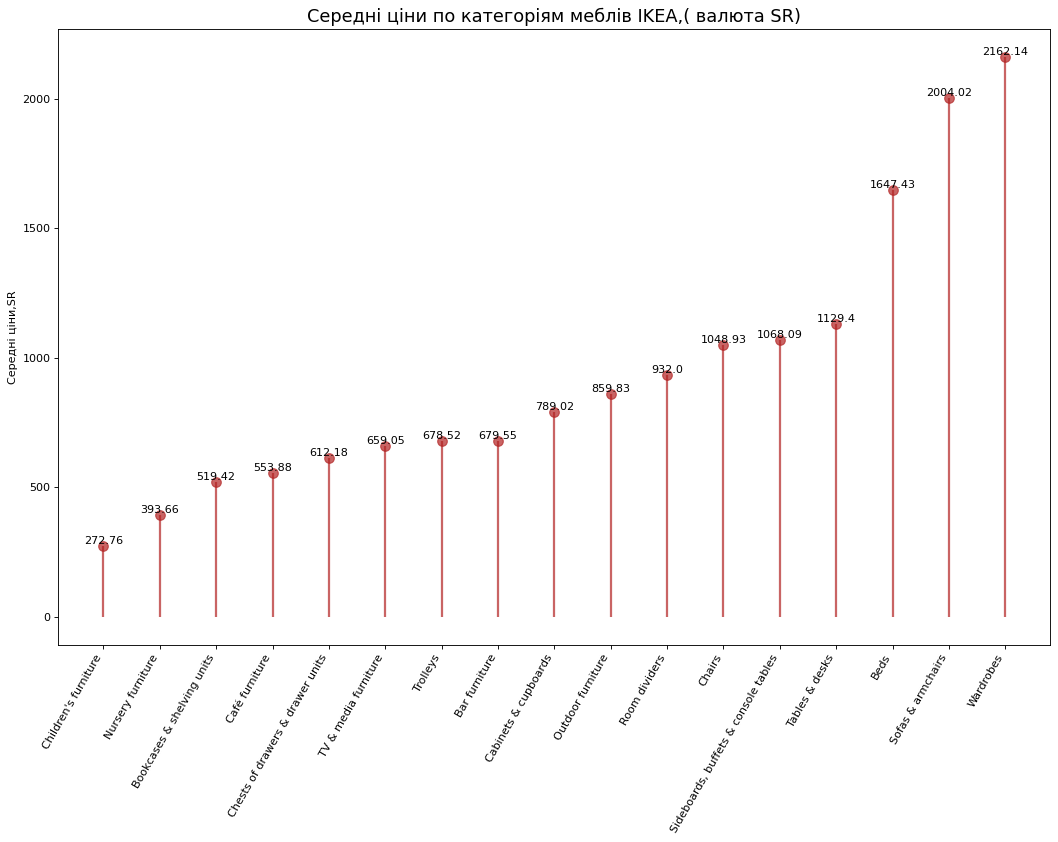

In [46]:
# Будуємо графік "Середні ціни по категоріям меблів IKEA"
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.vlines(x=df_categ.category, ymin=0, ymax=df_categ.price, color='firebrick', alpha=0.7, linewidth=2)
# Title, Label
ax.scatter(x=df_categ.category, y=df_categ.price, s=75, color='firebrick', alpha=0.7)
ax.set_title('Середні ціни по категоріям меблів IKEA,( валюта SR)', fontdict={'size':16})
ax.set_ylabel('Середні ціни,SR')
plt.xticks(df_ik.category, rotation=60, horizontalalignment='right', fontsize=10)
ax.set_xticks(df_categ.category)
for row in df_categ.itertuples():
    ax.text(row.category, row.price+.5, s=round(row.price, 2), horizontalalignment= 'center',
            verticalalignment='bottom', fontsize=10)
plt.show()

Побудований графік підтверджує правильність прийняття нами альтернативної гіпотези, а саме: середні ціни товарів залежать від категорії товарів

#4
4. Навчіть модель передбачати ціну на меблі.
Вкажіть, які стовпці не слід включати до моделі та чому.
Створіть конвеєр перехресної перевірки для навчання та оцінки
моделі, включаючи (при необхідності) такі кроки як
пропущених значень та нормалізація.
Запропонуйте методи підвищення продуктивності моделі.
Опишіть результати

In [51]:
# підгружаємо потрібні інструменти
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

Перед навченням моделі доцільно видалити стовбці які не впливають на ціну:
'Unnamed:', 'item_id', 'name', 'description of furniture','short_description'

In [52]:
# Виключення стовбців
df_model = df_ik.drop(['Unnamed: 0', 'item_id', 'name', 'description of furniture','short_description'], axis=1)

In [14]:
print(f"\n{df_model}")



           category   price  old_price  sellable_online other_colors  \
0     Bar furniture   265.0      265.0             True           No   
1     Bar furniture   995.0      995.0            False           No   
2     Bar furniture  2095.0     2095.0            False           No   
3     Bar furniture    69.0       69.0             True          Yes   
4     Bar furniture   225.0      225.0             True           No   
...             ...     ...        ...              ...          ...   
3689      Wardrobes   750.0      820.0             True           No   
3690      Wardrobes  1572.0     1755.0             True           No   
3691      Wardrobes   924.0     1050.0             True           No   
3692      Wardrobes  2745.0     3130.0             True           No   
3693      Wardrobes  1231.0     1535.0             True           No   

                  designer  
0     Nicholai Wiig Hansen  
1        Francis Cayouette  
2        Francis Cayouette  
3            Henri

In [53]:
#Перед застосуванням машинного навчання не числові колонки('category','sellable_online','other_colors','designer')
# потібно перетворити в числові.Для цих потреб використовую метод 1-hot ecoding
from sklearn.preprocessing import OneHotEncoder

In [54]:
ohe = OneHotEncoder()
arr_hot_encoded = ohe.fit_transform(df_model[['category','sellable_online','other_colors','designer']]).toarray()

In [18]:
print(arr_hot_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [55]:
# Array to df
df_hot_encoded = pandas.DataFrame(arr_hot_encoded, index=df_model.index)

In [56]:
# Видаляємо категорійни колонки з DF
df_model_1=df_model.drop(columns=['category','sellable_online','other_colors','designer'])

In [57]:
# Сципляємо DF
df_model_exit = pandas.concat([df_hot_encoded,df_model_1], axis=1)

In [22]:
 print(df_model_exit)

        0    1    2    3    4    5    6    7    8    9  ...  293  294  295  \
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3689  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3690  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3691  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3692  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3693  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      296  297  298  299  300   price  old_price  
0     0.0  0

In [ ]:
#Використовую лінійну регресію та  StandardScaler - для нормалізації данних
model_LR= Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
# split data
X = df_model_exit.drop(['price'], axis=1)
y = df_model_exit['price']
X.columns = X.columns.astype(str)
# Крос-валідація (перехресна перевірка) для оцінки ефективності моделі
# Кількість груп розподіленних данних = 5 (cv=5. П'ятикратна перевірка данних)
scores1= cross_val_score(model_LR, X,y, cv=5, scoring = 'r2')

In [ ]:
print('R2 scores:',scores1)
print('Mean R2 score:',scores1.mean())

Резльтати оцінки є коєфіцієнт детермінації (від 0 до 1 ), 1 - повна відповідність між фактичними та 
передбачувальними значеннями, 0 - повна відстність зв'язку.

Крос-валідація з використанням конвєйра дозволяє оцінити ефективність моделі на різних наборах данних, 
що допомогає уникнти перенавчання моделі.
В данному випадку коєфіцієнт R2 дорівнює 0,99, тобто модель передбачає ціну на товари з верегідностю 99%.

R2 scores: [0.99982143 0.96935322 0.99978354 0.9999996  0.99823964]
Mean R2 score: 0.9934394861398228

In [ ]:
# Розглянемо модель прогнозвання DecisionTreeRegressor
from  sklearn.tree import DecisionTreeRegressor
model_DTR =Pipeline ([
    ('scaler', StandardScaler()),
    ('regressor', DecisionTreeRegressor())

])
from sklearn.neighbors import KNeighborsRegressor
model_KNR = Pipeline ([
    ('scaler', StandardScaler()),
    ('regrssor',KNeighborsRegressor(n_neighbors=5))
])
# Розділення данних
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)
model_LR.fit(X_train, y_train) # для оцінки без кросс-валідції
model_DTR.fit(X_train, y_train)
model_KNR.fit(X_train,y_train)

In [ ]:
# Розраховємо MSЕ(середньоквадратичне помилка) та R2 (коеф.детермінації) для оцінки ефективності моделі
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mse_LR = mean_squared_error(y_test,model_LR.predict(X_test))
R2_LR = r2_score(y_test, model_LR.predict(X_test))
print(f"\nModel_LR result:\nMSE = {mse_LR}, R2={R2_LR}")

Model_LR result:
MSE = 17.47250404211853, R2=0.9999910096951207


In [ ]:
mse_DTR = mean_squared_error(y_test,model_DTR.predict(X_test))
R2_DTR = r2_score(y_test, model_DTR.predict(X_test))
print(f"\nModel_DTR result:\nMSE = {mse_DTR}, R2={R2_DTR}")

Model_DTR result:
MSE = 6499.071569264068, R2=0.9966559667292552

In [ ]:
mse_KNR = mean_squared_error(y_test,model_KNR.predict(X_test))
R2_KNR = r2_score(y_test, model_KNR.predict(X_test))
print(f"\nModel_KNR result:\nMSE = {mse_KNR}, R2={R2_KNR}")

Model_KNR result:
MSE = 392940.9972125541, R2=0.7978160797101004

Модель в якої найнижчий показник MSE, та найбільший R2 -найкраще підходить для прогнозування результативного показника
Тобто, в цьому випадку найточніше спрогнозує ціну на товари - модель лінійної регресії (LinearRegression)

Для покращення ефективності конткретно цієї моделі, можно зробити наступні кроки:
1)_Використати інші спосби попередньої обробки данних, наприклад кластеризацію.
2)_Збільшити наповненість данних, наприклад, найти можливість доповнити данними про виручку чи кількість проданних одиниць,
собівартості товарів, націнку. Це дало б можливість більш точно прогнозувати ціну, а також подивитая рейтенг товарів по 
популярності та прибутковості.
В цілому ефективность моделі залежить від "якості" данних та вибору моделі(конфігурації конвейєра).